Nesse notebook haverá:

- Geração dos embeddings da base (colocar em df_embeddings)
- Geração dos subespaços e identificação dos centróides (um df por cada subespaço + centroides do subespaço (com coluna is_centroid))
- DF unificado com as classificações (id_produto, grupo_produto, cor e etc)

### Bibliotecas

In [160]:
import requests
import pandas as pd
import torch

# acessando o bucket do s3
import boto3
import os
import dotenv

# importando o modelo
from sentence_transformers import SentenceTransformer, util
from PIL import Image, ImageFile
import logging

# subespaços
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from umap.umap_ import UMAP

from matplotlib import pyplot as plt

# centroids
import plotly.graph_objects as go

### Funções

In [161]:
def list_images_in_s3(s3_client, bucket_name, log=False, pasta=None):
    """
    Lista os arquivos de um bucket do S3.
    Parâmetros:
    - s3_client: cliente boto3 para acessar o S3
    - bucket_name: nome do bucket a ser acessado
    - log: se True, exibe informações sobre o bucket
    - pasta: pasta a ser acessada no bucket
    Retorna:
    - lista de arquivos no bucket
    """

    total_size = 0
    num_files = 0
    images = []
    continuation_token = None

    while True:
        if continuation_token:
            response = s3_client.list_objects_v2(
                Bucket=bucket_name,
                ContinuationToken=continuation_token
            )
        else:
            response = s3_client.list_objects_v2(
                Bucket=bucket_name
            )

        if 'Contents' in response:
            for item in response['Contents']:
                if pasta and not item['Key'].startswith(pasta):
                    continue
                images.append(item['Key'])
                total_size += item['Size']
                num_files += 1

                # Interrompe quando atingir o limite de 5.000 objetos
                if num_files >= 2000:
                    break

        # Verifica se há mais páginas a serem buscadas
        if response.get('IsTruncated') and num_files < 2000:
            continuation_token = response['NextContinuationToken']
        else:
            break

    if log:
        if num_files == 0:
            print("O bucket está vazio.")
        else:
            print(f"> Total de arquivos: {num_files}, Tamanho total: {total_size/1024**2:.2f} MB")
    return images

In [162]:
import boto3
import requests
from PIL import Image
from io import BytesIO
import pandas as pd
import numpy as np
from tqdm import tqdm

# Função para carregar imagem
def load_image(url_or_path):
    try:
        if url_or_path.startswith("http://") or url_or_path.startswith("https://"):

            # Fazer o download da imagem
            response = requests.get(url_or_path)
            response.raise_for_status()  # Verifica se houve erro na requisição

            # Carregar a imagem no Pillow
            image = Image.open(BytesIO(response.content))

            return image
        else:
            return Image.open(url_or_path)
    except Exception as e:
        print(f"Erro ao carregar a imagem: {url_or_path}. Detalhes: {e}")
        return None     

from typing import List

def get_img_embeddings_in_batches(
    df: pd.DataFrame,
    path_column: str,
    img_model: SentenceTransformer,
    batch_size: int = 16
) -> pd.DataFrame:
    """
    Função que processa imagens em batches para evitar sobrecarga de memória.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os caminhos das imagens.
        path_column (str): Nome da coluna no DataFrame com os caminhos das imagens.
        img_model (SentenceTransformer): Modelo para geração de embeddings das imagens.
        batch_size (int): Tamanho do batch para processar as imagens.

    Retorna:
        pd.DataFrame: DataFrame com os embeddings das imagens.
    """
    emb_columns = [f"emb_img_{i}" for i in range(512)]
    emb_dict = {}

    file_names = df[path_column].values
    ids = df["id_produto"].values

    # Processar as imagens em batches
    from tqdm import tqdm

    for start_idx in tqdm(range(0, len(file_names), batch_size), desc="Processando batches", position=0, leave=True):
        end_idx = min(start_idx + batch_size, len(file_names))
        batch_files = file_names[start_idx:end_idx]
        batch_ids = ids[start_idx:end_idx]

        valid_images = []
        valid_ids = []

        # tqdm.write("Carregando imagens...")  # Substituir print
        for img_path, img_id in tqdm(
            zip(batch_files, batch_ids),
            total=len(batch_files),
            desc="Carregando imagens",
            position=1,
            leave=False,
        ):
            img = load_image(img_path)
            if img is not None:
                valid_images.append(img)
                valid_ids.append(img_id)

        if valid_images:
            # tqdm.write("Gerando embeddings...")  # Substituir print
            batch_embeddings = img_model.encode(valid_images, show_progress_bar=False)

            for img_id, emb in zip(valid_ids, batch_embeddings):
                emb_dict[img_id] = emb

    # Criar DataFrame com embeddings
    df_embs = pd.DataFrame.from_dict(emb_dict, orient='index')
    df_embs.columns = emb_columns
    df_embs["id_produto"] = df_embs.index

    # Inserir NaN para produtos que falharam
    missing_ids = df[~df["id_produto"].isin(df_embs["id_produto"])]
    for missing_id in missing_ids["id_produto"]:
        df_embs = pd.concat([
            df_embs,
            pd.DataFrame([[np.nan] * 512 + [missing_id]], columns=emb_columns + ["id_produto"])
        ])

    # Resetar índice
    df_embs = df_embs.reset_index(drop=True)

    return df_embs


In [163]:
# Função que aplica LDA: recebe um df, as colunas desse df que contêm os embeddings e o número de componentes que se deseja obter
def apply_lda(df, colunas, n_components=2, lda=None, column_target='COR_PREDOMINANTE'):
    """
    Aplica LDA nos embeddings para redução de dimensionalidade com base na coluna passada como target,
    ignorando valores nulos na coluna de target e retornando um novo DataFrame com as colunas desejadas.
    """
    df_filtered = df.copy()

    if not lda:
        # Inicializando o modelo LDA
        lda = LinearDiscriminantAnalysis(n_components=n_components)

        # Filtrando os dados para remover nulos na coluna 'COR_PREDOMINANTE'
        df_filtered = df_filtered.dropna(subset=[f'{column_target}'])

        # Treinando o modelo e transformando os dados
        componentes = lda.fit_transform(df_filtered[colunas], df_filtered[f'{column_target}'])

        # Criando um novo DataFrame com as colunas desejadas
        df_lda = df_filtered[['id_produto', f'{column_target}']].copy()

    else:
        componentes = lda.transform(df_filtered[colunas])

        # Criando um novo DataFrame com as colunas desejadas
        df_lda = df_filtered[['id_produto']].copy()

    for i in range(n_components):
        df_lda[f'EMB_LDA_{i}'] = componentes[:, i]

    return df_lda, lda

def apply_umap(df, colunas, n_components=2, umap=None):
    """
    Aplica UMAP nos embeddings para redução de dimensionalidade
    """

    if umap is None:
        # Removendo linhas com valores nulos para treinar o modelo

        # Inicializando o modelo t-SNE
        umap = UMAP(n_components=n_components, random_state=42)

        # Treinando o modelo e transformando os dados
        componentes = umap.fit_transform(df[colunas])

        # Criando um novo DataFrame com as colunas desejadas
        df_umap = df[['id_produto']].copy() 
    else:
        # Transformando os dados
        componentes = umap.transform(df[colunas])

        # Criando um novo DataFrame com as colunas desejadas
        df_umap = df[['id_produto']].copy()

    for i in range(n_components):
        df_umap[f'EMB_UMAP_{i}'] = componentes[:, i]

    return df_umap, umap

In [164]:

# Função para plotar os componentes reduzidos com cores definidas por um dicionário
def plot_cores(df, cor_column='COR_PREDOMINANTE', reducer='LDA', color_dict=None, show=True):
    """
    Plota os componentes reduzidos colorindo os pontos com base em um dicionário de cores.
    """

    # Setando componente x e y conforme o reducer
    component_x, component_y = f'EMB_{reducer}_0', f'EMB_{reducer}_1'

    # Filtrando apenas as linhas que possuem valores válidos (sem NaN) nos componentes
    df_plot = df.dropna(subset=[component_x, component_y, cor_column])

    # Se o dicionário de cores não for fornecido, gerar um dicionário de cores padrão
    if color_dict is None:
        unique_colors = df_plot[cor_column].unique()
        color_dict = {color: plt.cm.tab20(i / len(unique_colors)) for i, color in enumerate(unique_colors)}

    # Removendo linhas com cores não mapeadas no dicionário de cores
    df_plot = df_plot[df_plot[cor_column].isin(color_dict.keys())]

    # Iterar por cada cor e plotar os pontos
    for cor, color_value in color_dict.items():
        subset = df_plot[df_plot[cor_column] == cor]
        
        # Adicionar borda preta se a cor for branca
        edge_color = 'black' if color_value == '#FFFFFF' else color_value

        plt.scatter(
            subset[component_x],
            subset[component_y],
            color=color_value,
            edgecolor=edge_color,  # Define a cor da borda
            linewidth=0.5 if color_value in ['#FFFFFF', '#F8F4E3'] else 0,  # Define a largura da borda para pontos brancos
            alpha=0.7,
            label=cor
        )

    # Botando a legenda deslocada para fora do gráfico
    plt.legend(title="COR_PREDOMINANTE", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel(component_x)
    plt.ylabel(component_y)
    plt.title(f"Componentes {reducer} com cores de {cor_column}")
    if show:
        plt.show()

In [165]:
# Dicionário de cores ajustado para cada valor de COR_PREDOMINANTE
color_dict = {
    'PRETO': '#000000',           # Preto puro
    'AZUL': '#1f77b4',            # Azul padrão
    'MULTICOLORIDO': '#000080',    # Cinza (para representar múltiplas cores de forma neutra)
    'VERDE': '#2ca02c',           # Verde padrão
    'ROSA': '#ff69b4',            # Rosa vibrante
    'BEGE': '#D2B48C',            # Bege suave
    'AMARELO': '#ffdd57',         # Amarelo claro
    'VERMELHO': '#d62728',        # Vermelho escuro
    'LARANJA': '#ff7f0e',         # Laranja padrão
    'ROXO': '#9467bd',            # Roxo médio
    'BRANCO': '#FFFFFF',          # Branco puro
    'MARROM': '#8B4513',          # Marrom escuro
}


In [166]:
def calcular_centroides(df, colunas, target_column):
    """
    Calcula os centróides para cada categoria em 'target_column' com base nas colunas fornecidas.
    Retorna um DataFrame com os centróides e a categoria correspondente.
    """
    
    # 1. Calcular os centróides para cada {target_column}
    df_centroides = df.drop(columns={'id_produto'}).groupby(f'{target_column}').mean().reset_index()

    # 2. Adicionar a coluna 'id_produto' aos centróides
    df_centroides['id_produto'] = df_centroides[f'{target_column}'].apply(lambda x: f'CLUSTER_{x}')

    # 3. Adicionar uma coluna para identificar os centróides
    df_centroides['is_centroid'] = True
    
    df['is_centroid'] = False  # Para os dados originais

    # 4. Concatenar os dados originais com os centróides
    df_combined = pd.concat([df, df_centroides], ignore_index=True)

    return df_combined

In [167]:
import plotly.graph_objects as go

def plot_clusters_with_centroids(
    df_combined, 
    target_column, 
    embedding_columns, 
    color_dict=None, 
    title="Visualização de Clusters com Centróides", 
    apply_umap=False, 
    umap_params=None,
    is_1d=False
):
    """
    Cria um gráfico de dispersão interativo com os clusters e seus centróides.
    
    Parâmetros:
    - df_combined: DataFrame contendo os dados originais e os centróides.
    - target_column: Nome da coluna que contém as categorias dos clusters.
    - embedding_columns: Lista com os nomes das colunas de embeddings.
    - color_dict: Dicionário com as cores específicas para cada categoria. Default: cores automáticas.
    - title: Título do gráfico. Default: "Visualização de Clusters com Centróides".
    - apply_umap: Booleano indicando se UMAP deve ser aplicado. Default: False.
    - umap_params: Dicionário com parâmetros para o UMAP. Default: None.
    - is_1d: Booleano indicando se os dados são unidimensionais. Default: False.
    
    Retorna:
    - Objeto Figure do Plotly.
    """
    # Aplicar UMAP se solicitado
    if apply_umap:
        umap_params = umap_params or {'n_neighbors': 15, 'n_components': 2, 'random_state': 42}
        umap = UMAP(**umap_params)
        
        embeddings = df_combined[embedding_columns].values
        umap_embeddings = umap.fit_transform(embeddings)

        # Adicionar os embeddings reduzidos ao DataFrame
        df_combined['UMAP_0'] = umap_embeddings[:, 0]
        if not is_1d:
            df_combined['UMAP_1'] = umap_embeddings[:, 1]

        # Ajustar as colunas para o gráfico
        embedding_columns = ['UMAP_0'] if is_1d else ['UMAP_0', 'UMAP_1']

    # Separar dados originais e centróides
    df_original = df_combined[df_combined['is_centroid'] == False].copy()
    df_original['Tipo'] = 'Original'

    df_centroids = df_combined[df_combined['is_centroid'] == True].copy()
    df_centroids['Tipo'] = 'Centróide'

    # Gerar um dicionário de cores se não fornecido
    if color_dict is None:
        categorias = df_original[target_column].unique()
        # Setando paleta de cores do tableau
        color_palette = [
            '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
            '#ff9896', '#aec7e8', '#ffbb78', '#98df8a'
        ]
        color_dict = {categoria: color_palette[i % len(color_palette)] for i, categoria in enumerate(categorias)}

    # Criação do gráfico com Plotly
    fig = go.Figure()

    # Adicionar os pontos dos dados originais por categoria
    for categoria, cor in color_dict.items():
        subset = df_original[df_original[target_column] == categoria]
        fig.add_trace(go.Scatter(
            x=subset[embedding_columns[0]],
            y=[0] * len(subset) if is_1d else subset[embedding_columns[1]],
            mode='markers',
            marker=dict(color=cor, size=8, line=dict(width=1, color='black')),
            name=f'{categoria}',
            hoverinfo='text',
            text=subset['id_produto']
        ))

    # Adicionar os centróides com cor fixa
    fig.add_trace(go.Scatter(
        x=df_centroids[embedding_columns[0]],
        y=[0] * len(df_centroids) if is_1d else df_centroids[embedding_columns[1]],
        mode='markers',
        marker=dict(color='red', symbol='x', size=10, line=dict(width=0.5)),
        name='Centróides',
        hoverinfo='text',
        text=df_centroids['id_produto']
    ))

    # Configuração do layout
    fig.update_layout(
        title=title,
        xaxis_title=f'{embedding_columns[0]}',
        yaxis_title='' if is_1d else f'{embedding_columns[1]}',
        legend_title='Legenda',
        template='plotly_white',
        hovermode='closest'
    )

    if is_1d:
        fig.update_layout(
            yaxis=dict(showgrid=False, showticklabels=False, zeroline=False)
        )

    return fig

In [ ]:
def plot_image_from_url(url):
    """
    Plota uma imagem a partir de uma URL fornecida.
    """
    try:
        # Fazendo o download da imagem
        response = requests.get(url)
        response.raise_for_status()  # Verifica se houve erro na requisição

        # Tentando abrir a imagem
        image = Image.open(BytesIO(response.content))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Erro ao carregar a imagem: {url}. Detalhes: {e}")


## Passo 1: dataframe com os embeddings das imagens da base

Puxamos as imagens do bucket em que estão armazenadas e geramos os embeddings.

### Base de imagens

Carregando as credenciais do bucket em que as imagens estão armazenadas.

In [169]:
dotenv.load_dotenv()

aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID'),
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')
if not aws_access_key_id or not aws_secret_access_key:
    raise ValueError("AWS_ACCESS_KEY_ID and AWS_SECRET_ACCESS_KEY must be set as environment variables")

s3 = boto3.client('s3')
response = s3.list_buckets()

print("Buckets disponíveis:")
for bucket in response['Buckets']:
    print(f"- {bucket['Name']}")

s3_client = boto3.client('s3')
bucket_name = 'animaleproductsimages'

Buckets disponíveis:
- animaleproductsimages


In [170]:
# Listando arquivos no bucket
file_list = list_images_in_s3(s3_client, bucket_name, log=True, pasta='foto_cortada')

> Total de arquivos: 766, Tamanho total: 9.66 MB


In [171]:
# Criando dataframe com os nomes de file_list
df = pd.DataFrame(file_list, columns=['file_name'])

# Criando coluna de id com o que está depois do último '_'
df['id_produto'] = df['file_name'].apply(lambda x: x.split('_')[-1].split('.')[0])

In [172]:
pasta = "foto_cortada"

def get_link(file_name):
    """
    Função que recebe o nome do arquivo e retorna o link para download
    """
    return f"https://animaleproductsimages.s3.us-east-1.amazonaws.com/{file_name}"

# Criando coluna com link para download
df['link'] = df['file_name'].apply(get_link)

In [173]:
df['link'][0]

'https://animaleproductsimages.s3.us-east-1.amazonaws.com/foto_cortada/blazer_blazer-alfaiataria-est-onca-jacquard_bege_03-04-0464-0030.jpg'

In [174]:
df.sample(3)

,file_name,id_produto,link
753,foto_cortada/vestido_vestido-ombro-a-ombro-lis...,07-20-6348-09612,https://animaleproductsimages.s3.us-east-1.ama...
446,foto_cortada/top-blusa_regata-de-malha-rib-lar...,52-15-1408-09249,https://animaleproductsimages.s3.us-east-1.ama...
534,foto_cortada/top-blusa_top-de-tricot-faixa-cru...,52-10-5277-03045,https://animaleproductsimages.s3.us-east-1.ama...


### Importando modelo

In [ ]:
# Configura o nível de logging para ERROR
logging.getLogger("sentence_transformers").setLevel(logging.ERROR)

# We use the original clip-ViT-B-32 for encoding images
img_model = SentenceTransformer('clip-ViT-B-32')

# Our text embedding model is aligned to the img_model and maps 50+
# languages to the same vector space
text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32-multilingual-v1')

### Geração dos embeddings

Cria um dataframe com os embeddings de cada imagem.

In [27]:
df_img_embs = get_img_embeddings_in_batches(df, "link", img_model)

Processando batches: 100%|██████████| 48/48 [08:46<00:00, 10.96s/it]


In [176]:
df_img_embs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Columns: 513 entries, emb_img_0 to id_produto
dtypes: float32(512), object(1)
memory usage: 1.5+ MB


In [177]:
df_img_embs.sample(3)

,emb_img_0,emb_img_1,emb_img_2,emb_img_3,emb_img_4,emb_img_5,emb_img_6,emb_img_7,emb_img_8,emb_img_9,...,emb_img_503,emb_img_504,emb_img_505,emb_img_506,emb_img_507,emb_img_508,emb_img_509,emb_img_510,emb_img_511,id_produto
170,0.105942,0.028344,-0.127322,0.540648,-0.422057,0.017786,-0.573057,-0.879370,0.497723,-0.172223,...,-0.195224,0.289401,0.130925,-0.174604,-0.260082,0.050298,1.339853,-0.476933,0.454151,25-34-1633-6215
595,0.075732,0.255321,-0.111697,0.169592,-0.420242,-0.071682,-0.250377,0.132627,0.912433,-0.005756,...,0.158266,0.856898,-0.262467,-0.318033,-0.103088,0.430286,0.215009,-0.028796,0.068894,07-20-6472-09249
522,-0.034873,0.256568,-0.023450,-0.062673,0.107196,-0.162073,-0.382141,0.208281,0.595690,-0.061064,...,-0.087050,0.340771,-0.274847,-0.175491,-0.125582,0.272690,0.117207,-0.067563,0.443101,52-10-5291-0005


In [178]:
df_img_embs.to_parquet("datasets/img_embeddings.parquet")

## Passo 2: Geração dos subespaços

Cruza a base df_img_embs com a base que temos armazenada que já está tagueada, se não houver correspondência em alguma decidimos agora o que fazer (taguear na mão, etc)

- cor_predominante -> pilar cor
- regex da estampa -> pilar estampa (ESSE DA PRA TIRAR DO FILE_NAME)
- informações tagueadas de modelagem -> pilar modelagem

In [179]:
# Puxando arquivo com categorização de cada produto id
df_categories = pd.read_parquet('../../TESTES E EXPERIMENTOS/datasets/base.parquet')

In [180]:
df_categories.sample(3)

,file_path,id_produto,grupo_produto,file_name,link,PRODUTOS,CARACTERISTICAS,LOCALIZACAO_ESTAMPA,COR_PREDOMINANTE,DECOTE_OU_GOLA,...,ESTILO,TIPO_MANGA,TIPO_CINTURA,COMPRIMENTO,MODELAGEM,ESTAMPA,FENDA_PERNA,MODELAGEM_SAIA,TIPO_BARRA,desc_produto
134,animale_images_cropped/calca/calca_calca-jeans...,25-34-2059-1530,calca,calca_calca-jeans-bomber-com-elastico_jeans-cl...,https://animaleproductsimages.s3.us-east-1.ama...,25-34-2059-1530,{COMPRIMENTO: MEIO_COXA;TIPO_CINTURA: MEDIA;MO...,N/A,JEANS,None,...,CASUAL,None,MEDIA,MEIO_COXA,CARGO,SEM_ESTAMPA,N/A,None,AJUSTADA,calca jeans bomber com elastico
609,animale_images_cropped/vestido/vestido_vestido...,07-20-6486-09561,vestido,vestido_vestido-de-georgette-longo-babados-est...,https://animaleproductsimages.s3.us-east-1.ama...,07-20-6486-09561,{COMPRIMENTO_SAIA: CALCANHAR;COMPRIMENTO_MANGA...,ROUPA_INTEIRA,AZUL,V,...,CASUAL,N/A,None,None,None,FLORAL,N/A,GODÊ,None,vestido de georgette longo babados estampado d...
40,animale_images_cropped/calca/calca_calca-com-r...,25-34-1615-0030,calca,calca_calca-com-recorte-lateral-est-onca_bege_...,https://animaleproductsimages.s3.us-east-1.ama...,25-34-1615-0030,{COMPRIMENTO: MEIO_COXA;TIPO_CINTURA: MEDIA;MO...,ROUPA_INTEIRA,BEGE,None,...,CASUAL,None,MEDIA,MEIO_COXA,FLARE,ANIMALPRINT_ONCA,N/A,None,RETA,calca com recorte lateral est onca


In [181]:
# Nesse momento cruzamos df_categories e df_img_embs e analisamos o que não tiver correspondência
df_categories = df_categories.merge(df_img_embs, on='id_produto', how='left')

# Aproveitando e puxando a coluna link de df para df_categories
df_categories = df_categories.drop(columns={'link'}).merge(df[['id_produto', 'link']], on='id_produto', how='left')

In [182]:
df_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Columns: 536 entries, file_path to link
dtypes: float32(512), object(24)
memory usage: 1.6+ MB


### Pilar de cor

In [183]:
# Definindo emb_cols
emb_cols = [col for col in df_categories.columns if 'emb_img' in col]

In [184]:
# colocar vinho em vermelho, lilás em roxo, jeans em azul, dourado em amarelo
df_categories['COR_PREDOMINANTE'] = df_categories['COR_PREDOMINANTE'].replace({
    'VINHO': 'VERMELHO',
    'LILÁS': 'ROXO',
    'JEANS': 'AZUL',
    'DOURADO': 'AMARELO',
    'OFF_WHITE': 'BRANCO',
    'CINZA': 'PRETO'
})

In [185]:
df_categories['COR_PREDOMINANTE'].value_counts()

COR_PREDOMINANTE
PRETO            198
BRANCO           116
BEGE             111
AZUL             104
VERDE             73
AMARELO           37
LARANJA           32
VERMELHO          30
ROSA              30
ROXO              15
MULTICOLORIDO     13
MARROM             7
Name: count, dtype: int64

In [186]:
# from utils.functions import apply_lda

# Aplicando LDA e retornando o DataFrame ajustado
df_lda_cor, lda_model_cor  = apply_lda(df_categories, emb_cols, 10, column_target='COR_PREDOMINANTE')

In [187]:
lda_model_cor

LinearDiscriminantAnalysis(n_components=10)

In [188]:
import pickle

# Salvando o modelo LDA
with open('models/lda_model_cor.pkl', 'wb') as f:
    pickle.dump(lda_model_cor, f)

In [189]:
# Função UMAP
colunas_lda = [col for col in df_lda_cor.columns if 'EMB_LDA' in col]

# Aplicando UMAP e retornando o DataFrame ajustado
df_umap_cor, umap_model = apply_umap(df_lda_cor, colunas_lda, 2)

C:\Users\Nicole.Souza.HOMLABNOT002581\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [190]:
# Puxando COR_PREDOMINANTE para colorir o scatter plot
df_umap_cor = pd.merge(df_umap_cor, df_categories[['id_produto', 'COR_PREDOMINANTE']], on='id_produto')

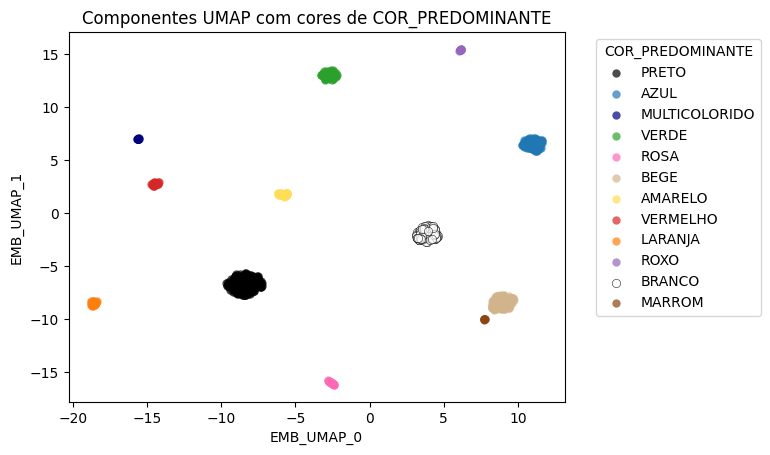

In [191]:
# Plotando o resultado do t-SNE
plot_cores(df_umap_cor, cor_column='COR_PREDOMINANTE', reducer='UMAP', color_dict=color_dict)

In [192]:
# Calcular os centróides de df_lda
df_centroides = calcular_centroides(df_lda_cor, colunas_lda, 'COR_PREDOMINANTE')

In [193]:
# Gerar o gráfico com UMAP
fig = plot_clusters_with_centroids(
    df_combined=df_centroides,
    target_column='COR_PREDOMINANTE',
    embedding_columns=colunas_lda,
    color_dict=color_dict,  # Opcional, pode ser None
    title="Visualização de Clusters com Centróides (LDA + UMAP)",
    apply_umap=True,
)

# Mostrar o gráfico
fig.show()

C:\Users\Nicole.Souza.HOMLABNOT002581\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



* REVISITAR DICT_CORES:
    - quais cores devem entrar?

(?) colocar mais exemplos cinza e marrom

#### Exemplo de classificação

Id Produto: 25-34-1208-09040


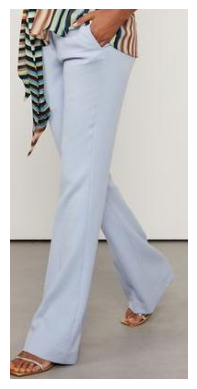

Centroide: CLUSTER_AZUL - Score: 3.09
Centroide: CLUSTER_BEGE - Score: 14.34
Centroide: CLUSTER_BRANCO - Score: 14.43


--------------------------------------------------
Id Produto: 07-20-6382-09607


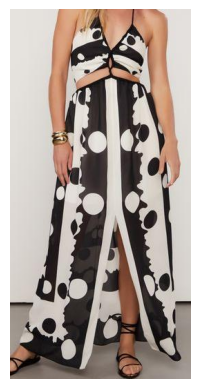

Centroide: CLUSTER_PRETO - Score: 3.79
Centroide: CLUSTER_BRANCO - Score: 11.28
Centroide: CLUSTER_BEGE - Score: 13.47


--------------------------------------------------
Id Produto: 25-34-1509-0005


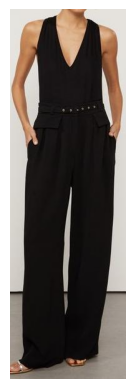

Centroide: CLUSTER_PRETO - Score: 3.27
Centroide: CLUSTER_BEGE - Score: 15.02
Centroide: CLUSTER_BRANCO - Score: 15.06


--------------------------------------------------
Id Produto: 07-20-6417-03023


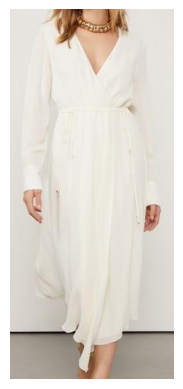

Centroide: CLUSTER_BRANCO - Score: 2.38
Centroide: CLUSTER_BEGE - Score: 12.39
Centroide: CLUSTER_AZUL - Score: 15.83


--------------------------------------------------
Id Produto: 07-20-6568-5471


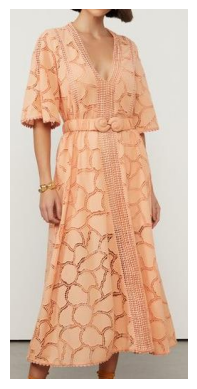

Centroide: CLUSTER_BEGE - Score: 4.87
Centroide: CLUSTER_MARROM - Score: 11.51
Centroide: CLUSTER_BRANCO - Score: 12.57


--------------------------------------------------


In [194]:
import random

# Pegando 10 imagens aleatórias
img_embs_lda = df_lda_cor[colunas_lda].values
sample_indexes = random.sample(range(img_embs_lda.shape[0]), 5)
img_embeddings_lda_sample = img_embs_lda[sample_indexes]
links = df_categories['link'].values[sample_indexes]

# Filtrando df_centroides pra pegar só os centroides
df_centroides_filtrado = df_centroides[df_centroides['is_centroid'] == True]
centroides = df_centroides_filtrado[colunas_lda].values
centroides = torch.tensor(centroides, dtype=torch.float32)

img_embeddings_lda_sample = torch.tensor(img_embeddings_lda_sample, dtype=torch.float32)

euclidean_dist = torch.cdist(img_embeddings_lda_sample, centroides, p=2)

# para cada imagem, vendo a semelhança com top 3 centroides mais próximos 
for i, distances in enumerate(euclidean_dist):
    print(f"Id Produto: {df_categories['id_produto'].values[sample_indexes[i]]}")
    plot_image_from_url(links[i])  # Plotando a imagem

    # Convertendo distances para NumPy, se necessário
    if isinstance(distances, torch.Tensor):
        distances = distances.cpu().numpy()
    
    # Obtendo os 3 índices com menor distância
    top_3_indices = distances.argsort()[:3]
    
    # Para cada imagem, vendo a semelhança com cada centroide mais próximo
    for idx in top_3_indices:
        # Pegando o nome do centroide e a distancia da imagem pra ele
        centroid_name = df_centroides_filtrado.iloc[idx]['id_produto']
        similar_score = distances[idx]
        print(f"Centroide: {centroid_name} - Score: {similar_score:.2f}")

    print("\n")
    print("-"*50)

In [195]:
df_centroides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 778 entries, 0 to 777
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id_produto        778 non-null    object 
 1   COR_PREDOMINANTE  778 non-null    object 
 2   EMB_LDA_0         778 non-null    float64
 3   EMB_LDA_1         778 non-null    float64
 4   EMB_LDA_2         778 non-null    float64
 5   EMB_LDA_3         778 non-null    float64
 6   EMB_LDA_4         778 non-null    float64
 7   EMB_LDA_5         778 non-null    float64
 8   EMB_LDA_6         778 non-null    float64
 9   EMB_LDA_7         778 non-null    float64
 10  EMB_LDA_8         778 non-null    float64
 11  EMB_LDA_9         778 non-null    float64
 12  is_centroid       778 non-null    bool   
 13  UMAP_0            778 non-null    float32
 14  UMAP_1            778 non-null    float32
dtypes: bool(1), float32(2), float64(10), object(2)
memory usage: 79.9+ KB


In [196]:
df_centroides['is_centroid'].value_counts()

is_centroid
False    766
True      12
Name: count, dtype: int64

In [197]:
df_centroides.sample(4)

,id_produto,COR_PREDOMINANTE,EMB_LDA_0,EMB_LDA_1,EMB_LDA_2,EMB_LDA_3,EMB_LDA_4,EMB_LDA_5,EMB_LDA_6,EMB_LDA_7,EMB_LDA_8,EMB_LDA_9,is_centroid,UMAP_0,UMAP_1
343,52-06-0637-0005,PRETO,8.783840,-3.439528,0.245209,-0.368473,-0.048643,-0.126432,2.216709,0.790283,0.091953,-1.240900,False,9.044806,2.015228
445,52-10-5169-09252,ROXO,-2.206357,1.249245,-5.064491,6.636338,7.909127,18.678870,0.401463,3.907067,-1.703446,-1.058305,False,11.145989,20.539316
125,25-34-1707-0005,PRETO,8.405224,-2.835428,-1.054229,0.241232,-0.088013,-0.849204,-0.405247,0.916102,-0.082072,-0.340002,False,9.052752,1.809179
771,CLUSTER_MARROM,MARROM,-4.926583,-3.988982,-3.292216,1.293580,0.519700,-1.425958,0.700339,8.573910,0.200884,-5.865402,True,12.496364,9.997618


In [198]:
# Salvando o DataFrame com os centróides 
df_centroides.to_parquet("datasets/df_subespace_cor.parquet")

### Pilar de Estampa

##### ESTAMPADO vs LISO

In [ ]:
# em file_name: pegar depois da barra o segundo '_'
df_categories['desc_produto'] = df_categories['file_name'].apply(lambda x: '_'.join(x.split('_')[1:3]))

In [200]:
df_categories['desc_produto'][0]

'blazer-alfaiataria-est-onca-jacquard_bege'

In [205]:
df_categories.loc[
    df_categories['desc_produto'].str.contains(r'-est', case=False, na=False)
]['desc_produto']

0              blazer-alfaiataria-est-onca-jacquard_bege
40               calca-com-recorte-lateral-est-onca_bege
63     calca-de-couro-estampa-cobra_est-cobra-biscion...
86     calca-de-georgette-com-cos-elastico-estampado_...
87     calca-de-georgette-com-pala-de-lastex-estampad...
                             ...                        
731    vestido-midi-de-georgette-leve-manga-longa-bar...
732    vestido-midi-de-georgette-pesado-de-alca-decot...
733    vestido-midi-de-georgette-pesado-manga-ampla-c...
743    vestido-midi-estampado-com-decote_est-pois-cic...
764    vestido-tule-babados-lili-est-leopardo_est-leo...
Name: desc_produto, Length: 112, dtype: object

In [233]:
df_categories['ESTAMPADO'] = df_categories['desc_produto'].str.contains(r'-est-|_est|estam', case=False, na=False)

In [234]:
df_categories['ESTAMPADO'].value_counts()

ESTAMPADO
False    631
True     135
Name: count, dtype: int64

In [235]:
df_categories.loc[df_categories['ESTAMPADO'] == False]['desc_produto'].sample(20)

655        vestido-de-malha-midi-bicolor-sem-alca_vermelho-fiery
19             calca-alfaiataria-linho-marrom-bordo_marrom-bordo
108               calca-de-sarja-black-loose-com-pespontos_preto
191               camisa-de-algodao-listrado-azul-maui_azul-maui
37                                 calca-com-cos-duplo-bege_bege
545                  short-de-sarja-mini-caramelo_caramelo-taffy
123                   calca-de-tricot-vazado-marrom_marrom-bordo
202     camisa-de-seda-basica-laranja-manga-longa_laranja-papaya
577                 vestido-de-couro-curto-decote-quadrado_preto
33                   calca-cargo-de-linho-com-tencel_azul-sereia
740               vestido-midi-de-tricot-sem-mangas-com-re_preto
168           calca-reta-com-fendas-de-crepe-off-white_off-white
163     calca-pantalona-plissada-com-cos-de-elastico-preta_preto
749                   vestido-mini-com-alca-de-renda-preto_preto
320                       blusa-manga-longa-drapeada-preta_preto
8                        

In [243]:
df_categories.loc[df_categories['id_produto'] == '52-13-5429-09050', 'ESTAMPADO'] = False

In [244]:
# Aplicando LDA 
df_lda_estampado, lda_estampado = apply_lda(df_categories, emb_cols, n_components=1, column_target='ESTAMPADO')

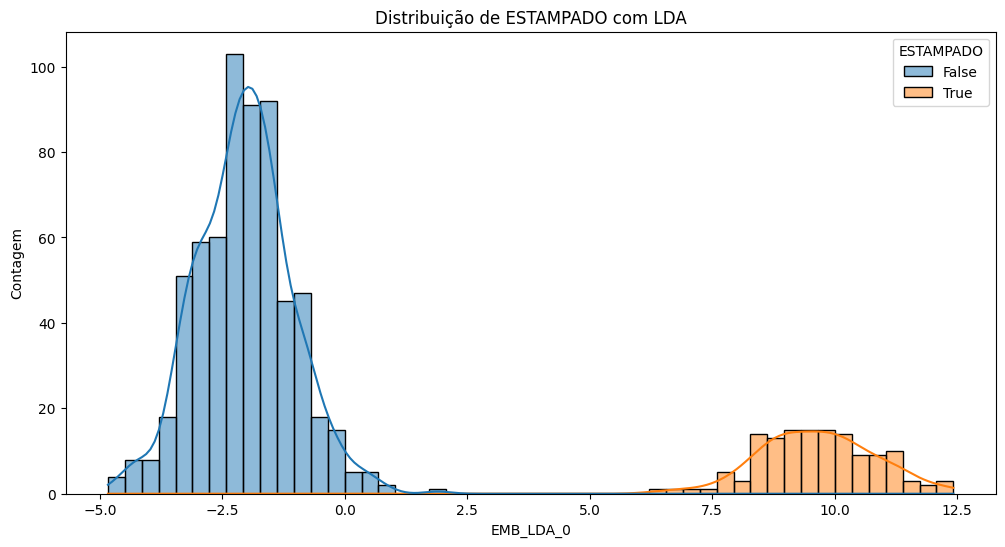

In [245]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_lda_estampado,
    x='EMB_LDA_0',
    hue='ESTAMPADO',
    kde=True,  # Para adicionar uma curva de densidade
    bins=50  # Número de bins
)
    
# Adicionar rótulos e título
plt.title('Distribuição de ESTAMPADO com LDA')
plt.xlabel('EMB_LDA_0')
plt.ylabel('Contagem')
plt.show()

In [246]:
colunas_lda = [col for col in df_lda_estampado.columns if col.startswith('EMB_LDA')]

# Calcular os centróides de df_lda_comprimento_saia
df_combined_estampado = calcular_centroides(df_lda_estampado, colunas_lda, 'ESTAMPADO')

In [247]:
fig = plot_clusters_with_centroids(
    df_combined=df_combined_estampado,
    target_column='ESTAMPADO',
    embedding_columns=colunas_lda,
    color_dict=None,
    title="Visualização Unidimensional",
    apply_umap=False,
    is_1d=True
)
fig.show()


In [285]:
df_combined_estampado['is_centroid'].value_counts()

is_centroid
False    766
True       2
Name: count, dtype: int64

In [286]:
df_combined_estampado.to_parquet("datasets/df_subespace_estampado.parquet")

In [315]:
# Salvando o modelo LDA
with open('models/lda_model_estampado.pkl', 'wb') as f:
    pickle.dump(lda_estampado, f)

##### ESTAMPAS

In [287]:
# PRODUTO COM CADASTRO ERRADO IDENTIFICADO
df_categories.loc[df_categories['id_produto'] == '52-13-5429-09050']['desc_produto']

# para resolver o problema, vamos trocar o cadastro desse produto manualmente para que ele não atrapalhe
# o subespaço constrúido

234    bata-de-georgette-leve-manga-longa-frente-frazida-estampada_vermelho-argila
Name: desc_produto, dtype: object

In [288]:
df_categories['estampa_cor'] = df_categories['desc_produto'].apply(lambda x: x.split('_')[1])

In [289]:
df_categories.loc[df_categories['ESTAMPADO'] == True][['desc_produto',  'estampa_cor']].sample(10)

# Verificando casos em que df_categories['ESTAMPADO'] == True mas estampa_cor não começa com 'est'
df_categories.loc[
    (df_categories['ESTAMPADO'] == True) & (~df_categories['estampa_cor'].str.contains(r'^est', case=False, na=False))
][['desc_produto', 'estampa_cor', 'id_produto']]

,desc_produto,estampa_cor,id_produto
0,blazer-alfaiataria-est-onca-jacquard_bege,bege,03-04-0464-0030
40,calca-com-recorte-lateral-est-onca_bege,bege,25-34-1615-0030
178,calca-slim-em-estampa-cobra_verde,verde,25-11-1175-0300
238,blusa-basica-de-tule-estampada-com-manga-longa_xadrez-daisy-kirli-e-cannes-p,xadrez-daisy-kirli-e-cannes-p,52-13-5426-09633
245,blusa-de-georgette-com-torcao-estampado_pois-passaro-marinho-p,pois-passaro-marinho-p,52-13-5396-09628
477,top-sem-mangas-est-onca-jacquard_bege,bege,52-10-5126-0030
484,mini-saia-em-estampa-cobra_verde,verde,25-11-1173-0300
616,vestido-de-georgette-midi-franzido-frente-estampado_floral-carimbo-golden,floral-carimbo-golden,07-20-6544-09738


In [290]:
# possiveis estampas: abstrato, onca, floral, cobra, grafico, aquarela, listra, pois, xadrez, folhagem, leopardo, geo 
dict_estampas = {
    'abstrato|peixes': 'abstrato',
    'onca': 'onca',
    'floral|camomila': 'floral',
    'cobra': 'cobra',
    # 'grafic': 'grafico',
    'aquarela': 'aquarela',
    'listra': 'listra',
    'pois': 'poa',
    'xadrez': 'xadrez',
    'folhagem': 'folhagem',
    'leopardo': 'leopardo',
    'geo|gravataria': 'geometrico'
}


# Inicializando a coluna como None
df_categories['ESTAMPA_CADASTRO'] = None

# Preenchendo com a estampa correspondente
for estampa, valor in dict_estampas.items():
    # Preenche apenas onde não há valor ainda e há correspondência
    mask = df_categories['desc_produto'].str.contains(estampa, case=False, na=False) & df_categories['ESTAMPA_CADASTRO'].isna() & df_categories['ESTAMPADO']
    df_categories.loc[mask, 'ESTAMPA_CADASTRO'] = valor


In [291]:
df_categories.sample(3)

,file_path,id_produto,grupo_produto,file_name,PRODUTOS,CARACTERISTICAS,LOCALIZACAO_ESTAMPA,COR_PREDOMINANTE,DECOTE_OU_GOLA,COMPRIMENTO_SAIA,...,emb_img_506,emb_img_507,emb_img_508,emb_img_509,emb_img_510,emb_img_511,link,ESTAMPADO,ESTAMPA_CADASTRO,estampa_cor
36,animale_images_cropped/calca/calca_calca-cenoura-detalhe-torcao-na-frente-azul_azul-print_25-34-1700-09246.jpg,25-34-1700-09246,calca,calca_calca-cenoura-detalhe-torcao-na-frente-azul_azul-print_25-34-1700-09246.jpg,25-34-1700-09246,{COMPRIMENTO: MEIO_CANELA;TIPO_CINTURA: MEDIA;MODELAGEM: SLIM;TIPO_BARRA: AJUSTADA;AMARRACAO: SIM_NA_FRENTE;FENDA_PERNA: N/A;COR_PREDOMINANTE: AZUL;LOCALIZACAO_ESTAMPA: N/A;ZOOM_ESTAMPA: N/A;ESTAMPA: SEM_ESTAMPA;ESTILO: CASUAL;},N/A,AZUL,None,None,...,-0.249306,-0.433163,-0.039776,1.080078,-0.471259,0.511664,https://animaleproductsimages.s3.us-east-1.amazonaws.com/foto_cortada/calca_calca-cenoura-detalhe-torcao-na-frente-azul_azul-print_25-34-1700-09246.jpg,False,None,azul-print
541,animale_images_cropped/short/short_short-de-georgette-leve-camadas-estampado_est-textura-peixes-golden-e-solsticio_25-11-1336-09822.jpg,25-11-1336-09822,short,short_short-de-georgette-leve-camadas-estampado_est-textura-peixes-golden-e-solsticio_25-11-1336-09822.jpg,25-11-1336-09822,{COMPRIMENTO: CURTO; MODELAGEM: SOLTA; TIPO_CINTURA: ALTA; TIPO_BARRA: AJUSTADA; AMARRACAO: SIM_NA_LATERAL; COR_PREDOMINANTE: AMARELO; LOCALIZACAO_ESTAMPA: ROUPA_INTEIRA; ZOOM_ESTAMPA: MEDIO; ESTAMPA: FLORAL; ESTILO: CASUAL;},ROUPA_INTEIRA,AMARELO,None,None,...,0.010198,-0.033160,0.100223,1.164777,-0.002204,0.047349,https://animaleproductsimages.s3.us-east-1.amazonaws.com/foto_cortada/short_short-de-georgette-leve-camadas-estampado_est-textura-peixes-golden-e-solsticio_25-11-1336-09822.jpg,True,abstrato,est-textura-peixes-golden-e-solsticio
742,animale_images_cropped/vestido/vestido_vestido-midi-decote-v-manga-longa-e-amarracao-nas-costas-liso_preto_07-20-6033-0005.jpg,07-20-6033-0005,vestido,vestido_vestido-midi-decote-v-manga-longa-e-amarracao-nas-costas-liso_preto_07-20-6033-0005.jpg,07-20-6033-0005,{COMPRIMENTO_SAIA: CALCANHAR;COMPRIMENTO_MANGA: LONGA;TIPO_MANGA: REGULAR;MODELAGEM_SAIA: EVASÊ;FENDA_PERNA: N/A;DECOTE_OU_GOLA: V;AMARRACAO: N/A;COR_PREDOMINANTE: PRETO;LOCALIZACAO_ESTAMPA: N/A;ZOOM_ESTAMPA: N/A;ESTAMPA: SEM_ESTAMPA;ESTILO: SOCIAL;},N/A,PRETO,V,CALCANHAR,...,-0.081671,-0.138493,0.093028,0.729861,-0.267321,0.111902,https://animaleproductsimages.s3.us-east-1.amazonaws.com/foto_cortada/vestido_vestido-midi-decote-v-manga-longa-e-amarracao-nas-costas-liso_preto_07-20-6033-0005.jpg,False,None,preto


In [292]:
df_categories['ESTAMPA_CADASTRO'].value_counts()

ESTAMPA_CADASTRO
floral        32
onca          30
poa           22
geometrico    14
cobra         10
listra         9
abstrato       7
xadrez         6
leopardo       2
folhagem       2
Name: count, dtype: int64

In [293]:
df_estampados = df_categories[df_categories['ESTAMPA_CADASTRO'].notnull()]

In [294]:
df_estampados['ESTAMPA_CADASTRO'].value_counts()

ESTAMPA_CADASTRO
floral        32
onca          30
poa           22
geometrico    14
cobra         10
listra         9
abstrato       7
xadrez         6
leopardo       2
folhagem       2
Name: count, dtype: int64

In [295]:
df_estampados['id_produto'].count()

134

In [296]:
# Aplicando LDA 
df_lda_estampa, lda_estampa = apply_lda(df_categories, emb_cols, n_components=9, column_target='ESTAMPA_CADASTRO')

In [297]:
colunas_lda = [col for col in df_lda_estampa.columns if col.startswith('EMB_LDA')]

# Calcular os centróides de df_lda_estampa
df_combined_estampa = calcular_centroides(df_lda_estampa, colunas_lda, 'ESTAMPA_CADASTRO')

In [298]:
# Lista das colunas de embeddings de alta dimensionalidade
embedding_columns = [col for col in df_lda_estampa.columns if col.startswith('EMB_LDA')]

fig = plot_clusters_with_centroids(
    df_combined=df_combined_estampa,
    target_column='ESTAMPA_CADASTRO',
    embedding_columns=embedding_columns,
    color_dict=None,
    title="Visualização com UMAP",
    apply_umap=True,
    is_1d=False
)
fig.show()


C:\Users\Nicole.Souza.HOMLABNOT002581\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [300]:
df_combined_estampa['is_centroid'].value_counts()

is_centroid
False    134
True      10
Name: count, dtype: int64

In [301]:
# Salvando o DataFrame com os centróides 
df_combined_estampa.to_parquet("datasets/df_subespace_estampa.parquet")

In [316]:
# Salvando o modelo LDA
with open('models/lda_model_estampa.pkl', 'wb') as f:
    pickle.dump(lda_estampa, f)

##### Exemplo de classificação

Id Produto: 03-04-0478-6048


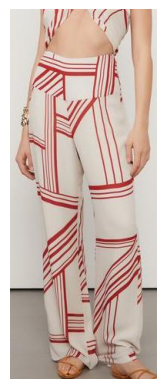

Centroide: CLUSTER_listra - Score: 1.83
Centroide: CLUSTER_poa - Score: 13.30
Centroide: CLUSTER_abstrato - Score: 13.39


--------------------------------------------------
Id Produto: 25-34-1595-09247


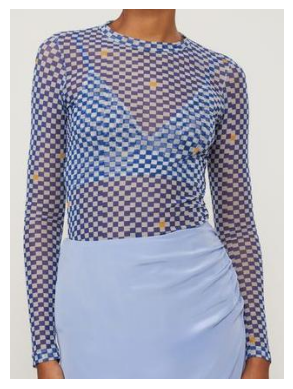

Centroide: CLUSTER_xadrez - Score: 2.52
Centroide: CLUSTER_listra - Score: 13.98
Centroide: CLUSTER_poa - Score: 14.65


--------------------------------------------------
Id Produto: 25-34-1627-0003


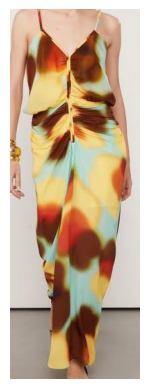

Centroide: CLUSTER_abstrato - Score: 2.09
Centroide: CLUSTER_floral - Score: 10.78
Centroide: CLUSTER_poa - Score: 12.55


--------------------------------------------------
Id Produto: 25-34-1642-09257


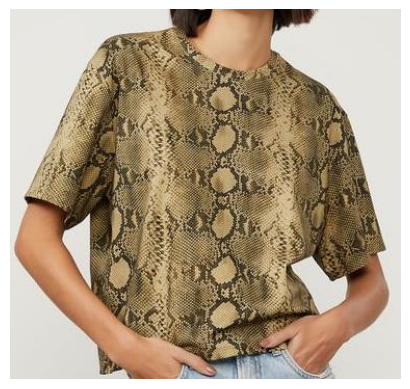

Centroide: CLUSTER_cobra - Score: 2.03
Centroide: CLUSTER_floral - Score: 8.32
Centroide: CLUSTER_poa - Score: 9.25


--------------------------------------------------
Id Produto: 25-34-1734-0005


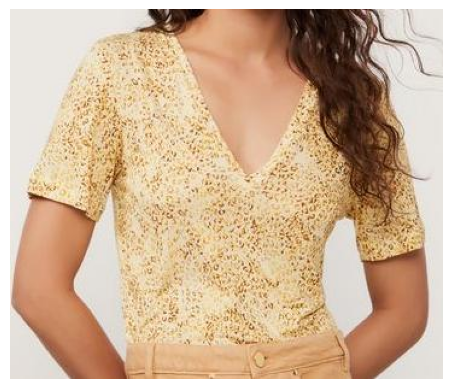

Centroide: CLUSTER_onca - Score: 2.69
Centroide: CLUSTER_floral - Score: 6.60
Centroide: CLUSTER_poa - Score: 7.77


--------------------------------------------------


In [312]:
# Pegando 10 imagens aleatórias
img_embs_lda = df_lda_estampa[colunas_lda].values
sample_indexes = random.sample(range(img_embs_lda.shape[0]), 5)
img_embeddings_lda_sample = img_embs_lda[sample_indexes]
links = df_categories.loc[df_categories['ESTAMPADO'] == True]['link'].values[sample_indexes]

# Filtrando df_combined_estampa pra pegar só os centroides
df_combined_estampa_filtrado = df_combined_estampa[df_combined_estampa['is_centroid'] == True]
centroides = df_combined_estampa_filtrado[colunas_lda].values
centroides = torch.tensor(centroides, dtype=torch.float32)

img_embeddings_lda_sample = torch.tensor(img_embeddings_lda_sample, dtype=torch.float32)

euclidean_dist = torch.cdist(img_embeddings_lda_sample, centroides, p=2)

# para cada imagem, vendo a semelhança com top 3 centroides mais próximos 
for i, distances in enumerate(euclidean_dist):
    print(f"Id Produto: {df_categories['id_produto'].values[sample_indexes[i]]}")
    # encontrar link de df_categories que corresponda ao id_produto
    plot_image_from_url(links[i])  # Plotando a imagem

    # Convertendo distances para NumPy, se necessário
    if isinstance(distances, torch.Tensor):
        distances = distances.cpu().numpy()
    
    # Obtendo os 3 índices com menor distância
    top_3_indices = distances.argsort()[:3]
    
    # Para cada imagem, vendo a semelhança com cada centroide mais próximo
    for idx in top_3_indices:
        # Pegando o nome do centroide e a distancia da imagem pra ele
        centroid_name = df_combined_estampa_filtrado.iloc[idx]['id_produto']
        similar_score = distances[idx]
        print(f"Centroide: {centroid_name} - Score: {similar_score:.2f}")

    print("\n")
    print("-"*50)

hoje:
- concluir notebook classificacao
- concluir notebook filtro

amanhã:
- concluir notebook rankeamento